#### **Predictive Maintenance of Jet Engines**, Delores Mincarelli, July 2023
**Business Goal** - Moving from preventive maintenance to predictive 
<br> *Is there a competitive advantage in how businesses manage their key assets?*

Predicting failures impacts the bottom line. Consider the following:

- Personnel Safety - catastrophic equipment failure can be deadly in certain industries.
- Inventory Management - avoid unplanned downtime by having parts when you need them, but, avoid having too much to keep costs down.
- Reducing costs - replacing equipment too early is wasteful, but, too late can lead to overtime costs to fix in off hours, and variation in planned throughput.

<br> On the other hand, predictions are not perfect.

- What is the cost of predicting a failure prematurely?
- What is the cost of an unplanned failure?
<br> 
<br> In this analysis, I assign costs to these prediction scenarios in order to find an “optimal” solution that works for a specific business scenario.

**Description of Dataset**
This data set is the Kaggle version of the very well known public data set for asset degradation modeling from NASA. We are given 100 simulated jet engine data, with over 20 sensor readings contaminated with considerable noise.

The goal is to predict the “Remaining Useful Life” (RUL) given sensor readings for a particular engine cycle (possibly equivalent to #flights or #days).

The dataset granularity is engine (unit_number) and cycle. Thus, one engine could have many records, each record pertaining to a specific cycle.

Each engine in the training dataset is run-to-failure. Thus we can precisely calculate the RUL for every cycle. However, the validation dataset has engines that are observed at a specific point in time; some are still running, and some have failed.

The dataset can be found here:
https://www.kaggle.com/datasets/behrad3d/nasa-cmaps https://www.nasa.gov/content/prognostics-center-of-excellence-data-set-repository**

**My Approach**
 - Simplify the problem for a quick win. Instead of predicting RUL, can we predict engines that have less than 30 cycles remaining before failure? This moves from a regression problem to a classification problem. I came to this conclusion after exploring the data and seeing clear demarcation between sensor values on both sides of this boundary. Presumably, 30 cycles would be enough time to secure parts needed for maintenance; this is where the business would need to weigh in. Certainly, the more lead time the better, but that also comes with less confidence in the prediction.

 - Use a specific type of recurrent neural network - "Long Short Terms Memory (LSTM)". 
The LSTM network is designed for sequence problems. Sequence prediction is different from other types of supervised learning problems. The sequence imposes an order on the observations that must be preserved when training models and making predictions.  Because we are given sensor snapshots over time for each engine, LSTM is the perfect application for this type of model. 

- Assign a penalty to false positives and negatives, and thus calculate the overall "cost" using different probability cutoff points.  (As we vary the probability, the number of false positives & negatives will shift, thus, we are looking for the lowest cost).  The optimal probability cutoff point used in the model training will be applied to the test dataset.  


**Conclusions** 
- Our metrics are:  precision, sensitivity, specificity.  Surprisingly, our test data outperformed training data.
- I assigned a high penalty cost to false negatives (vs false positives), so this drove the sensitivity to be perfect - **there were no false negatives when running the test data**.  
-  **Specificity was also excellent.**   Overall we struck a very good balance between predicting failures where there actually was a failure (sensitivity), and predicting a healthy engine when it actually was healthy (specificity).  
- The probability cutoff that powered these results was < 0.1, which compared to the default of 0.5 is biased toward the low end.  The cutoff is varied by altering the penalties, so this is something that can be adjusted by the business.  
- Overall, the LSTM model, using a window sequence of 50 records, with just a few hidden layers, did an excellent job when training the model.

**Suggestions for Improvements**
- Vary the sequence_length (moving window) used in the LSTM model to see if there is an optimal length.
- Vary the cycles that we used to define whether the unit was in the failure realm.  We used 30 in this scenario but we'd like to increase that window to increase lead time on recognizing failure.  
- Vary the number of LSTM and Dense layers - try to get the simplest model possible with tolerable results.
- Presumably, it would be costly to run engines to failure just to get data for predictions; so, use a subset of training data to simulate additional records programmatically,  and use the hybrid data to model to train an LSTM model.  Compare results with this dataset. 

In [1]:
# import the libraries
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets 
from keras.models import model_from_json
import matplotlib.pyplot as plt
import glob
import urllib
import itertools

# import the libraries for modeling
import tensorflow
import keras
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from sklearn import datasets
from keras.layers import Dense, Dropout, LSTM, Activation

#File Handling: h5py allows you to create, read, write, and manipulate HDF5 files using a simple and intuitive Pythonic interface
import h5py
import os


#### Import Train, Test datasets

In [2]:
# read training data 
train_raw_df = pd.read_csv('./data/train_FD001.txt', sep=" ", header=None)

# remove two columns that have NaN
# Drop columns 26 and 27
train_raw_df = train_raw_df.drop(columns=[26, 27])

# name the cols
train_raw_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_raw_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
# read test data
test_df = pd.read_csv('./data/test_FD001.txt', sep=" ", header=None)

# remove two columns that have NaN
# Drop columns 26 and 27
test_df = test_df.drop(columns=[26, 27])

# name the cols
test_df.columns = train_raw_df.columns


test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [4]:
# label data for test 
truth_df = pd.read_csv('./data/RUL_FD001.txt', sep=" ", header=None)

# Drop column 1 which is NaN
truth_df = truth_df.drop(columns=[1])

truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


#### Training Data: Processing
##### Calculate the RUL
Each of these units ran to failure.  Thus, the maximum cycle for each unit is the failure cycle.   We can use this to create the RUL of all the other cycles.

In [5]:
# create separate df with the unit id and the max cycle
rul = pd.DataFrame(train_raw_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul


,id,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [6]:
# join the two datasets on the unit id
train_df = train_raw_df.merge(rul, on=['id'], how='left')

# subtract cycle from the max cycles to get RUL
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df = train_df.drop(columns=[('max')])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


##### Create categorical labels
fail_in_30_label: If RUL <=30 then flag as a "1", failure within 30 cycles, else 0

In [7]:
cycle_cutoff = 30
train_df['fail_in_30_label'] = np.where(train_df['RUL'] <= cycle_cutoff, 1, 0 )
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,fail_in_30_label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


##### Normalize
The main idea behind normalization/standardization is always the same. Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem feature-wise normalization such as MinMax Scaling is usually used prior to model fitting.

By doing so, all features will be transformed into the range [0,1] meaning that the minimum and maximum value of a feature/variable is going to be 0 and 1, respectively.

x(scaled) = ( x - x(min) ) / ( x(max) - x(min) )

We want to preserve original data: id, cycle, RUL, fail_in_30_label for interpretation, and normalize everything else. 
Because cycle will be one of our predictors, we'll keep the original and create a copy that is normalized.

In [8]:
# create new cycle col
train_df['cycle_norm'] = train_df['cycle']

# get list of cols that we want to normalize
cols_normalize = train_df.columns.difference(['id','cycle','RUL','fail_in_30_label','label2'])
cols_normalize


Index(['cycle_norm', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's18', 's19', 's2', 's20', 's21', 's3', 's4', 's5', 's6', 's7',
       's8', 's9', 'setting1', 'setting2', 'setting3'],
      dtype='object')

In [9]:
# create minmax scaler object and then normalize cols
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)


#join the normalized data back to orig dataset, just getting the different cols
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,fail_in_30_label,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


#### Exploratory Data Analysis
##### Check for Nulls

In [10]:
null_counts = train_df.isnull().sum()
if null_counts.sum() > 0:
    print(null_counts)
else:
    print("There are no null values")

There are no null values


##### Summarize
Observations:  
- Looking at the min & max, we can see setting3, s1,s5,s10,s16,s18,s19 have zero variation, hence will not contribute to explaining our target. 
- sensor 6, (s6), has the same value for 25th, 50th, 75th percentile, so there is very little variation in values and will not contribute to explaining variation in our target.   

In [11]:
# summarize the normalized data - you can see the min = 0, max = 1 for each predictor
train_describe = train_df.describe().T
train_describe

,count,mean,std,min,25%,50%,75%,max
id,20631.0,51.506568,29.227633,1.0,26.000000,52.000000,77.000000,100.0
cycle,20631.0,108.807862,68.880990,1.0,52.000000,104.000000,156.000000,362.0
setting1,20631.0,0.499490,0.125708,0.0,0.413793,0.500000,0.586207,1.0
setting2,20631.0,0.501959,0.244218,0.0,0.333333,0.500000,0.750000,1.0
setting3,20631.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
s1,20631.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
s2,20631.0,0.443052,0.150618,0.0,0.335843,0.430723,0.539157,1.0
s3,20631.0,0.424746,0.133664,0.0,0.331807,0.415522,0.508829,1.0
s4,20631.0,0.450435,0.151935,0.0,0.339467,0.435348,0.545324,1.0
s5,20631.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [12]:
sensor_names=['s{}'.format(i) for i in range(1,22) ]
setting_names=['setting{}'.format(i) for i in range(1,4) ]
plot_cols = setting_names + sensor_names


##### Histograms
Observations:  Building on the observations from the summary data, above, we see: 
- setting3, s1,s5,s6,s10,s16,s18,s19 have zero or little variation, hence will not contribute to explaining our target.

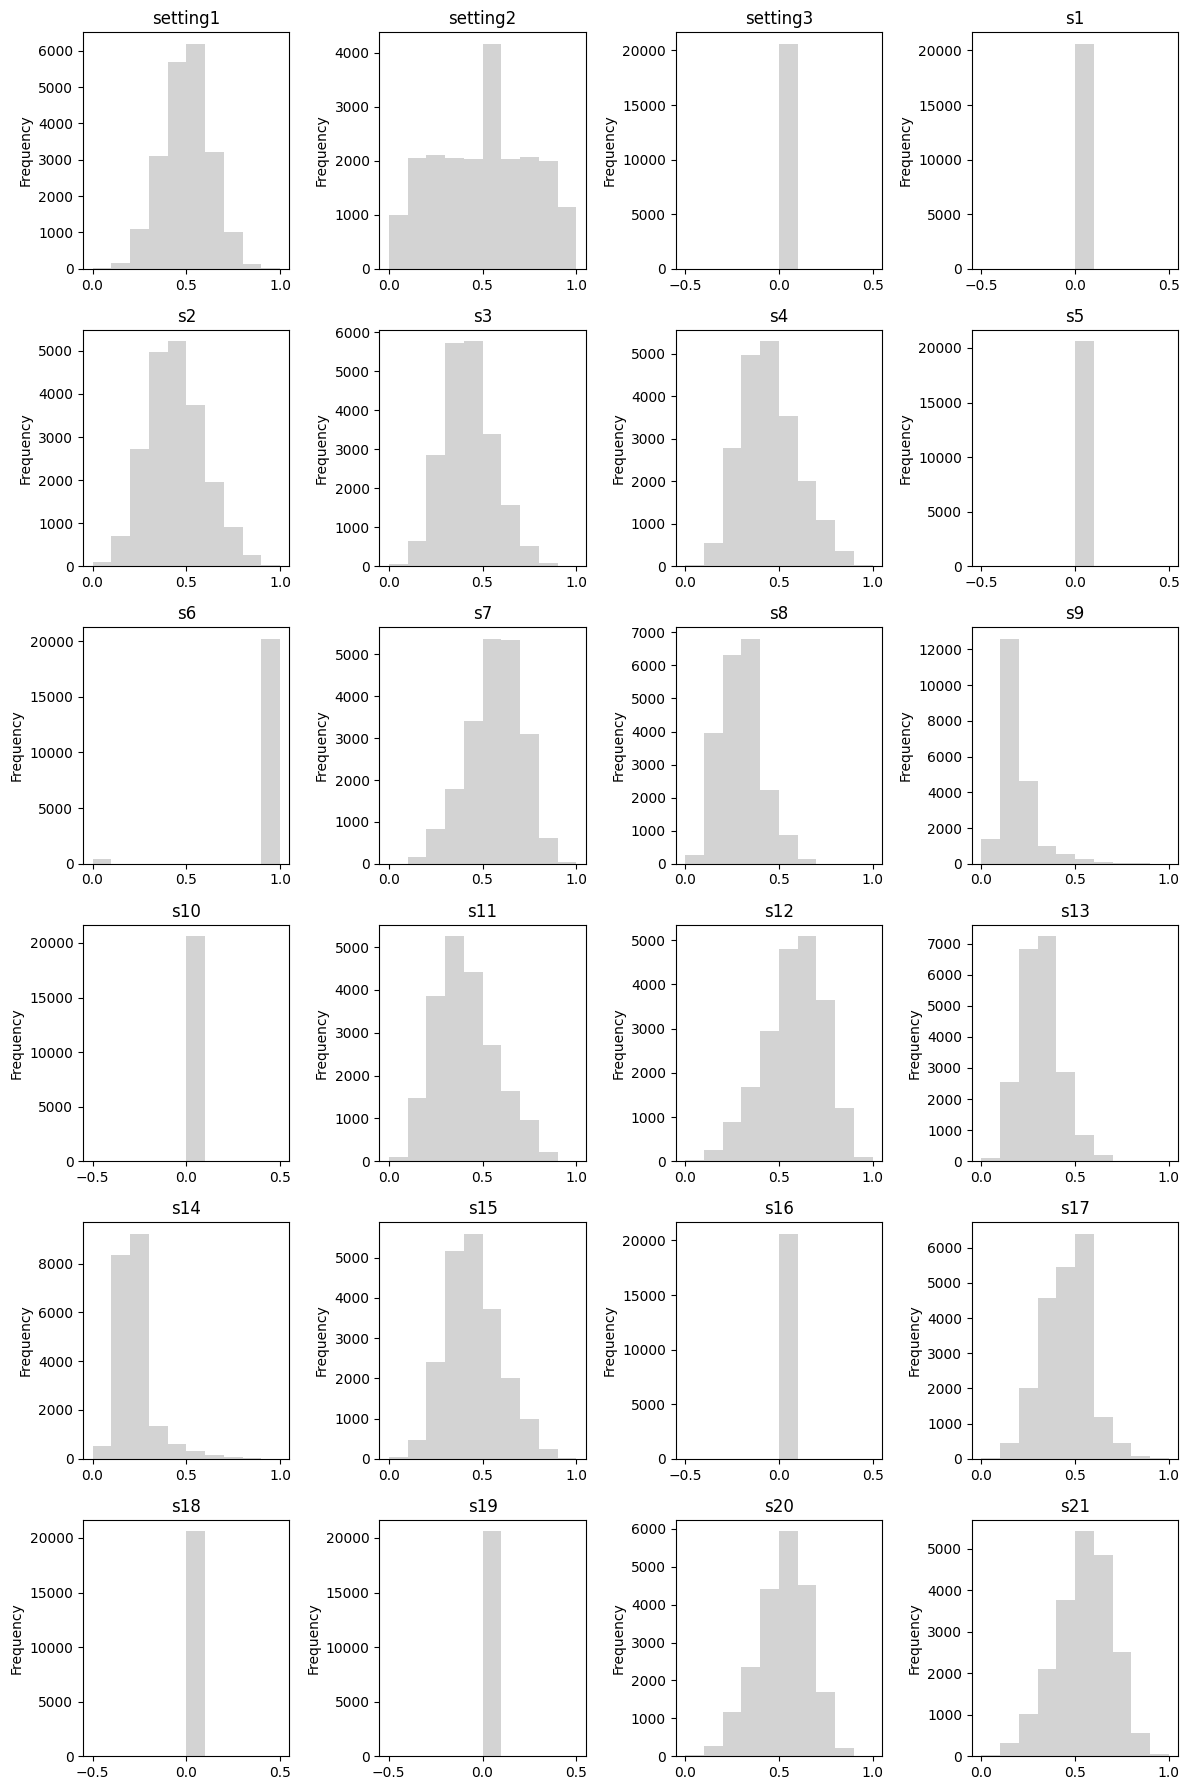

In [13]:
# Define the number of rows and columns in the grid
num_rows = 6
num_cols = 4

# Create a new figure and subplots with the desired grid layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 18))

# Iterate over the columns in hist_cols and create histograms
for i, col in enumerate(plot_cols):
    # Calculate the row and column indices for the current subplot
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Select the current subplot using the row and column indices
    ax = axes[row_idx, col_idx]

    # Create the histogram for the current column
    train_df[col].plot.hist(ax=ax, bins=10, color="lightgray")

    # Set the title of the subplot to the column name
    ax.set_title(col)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()


##### Line Charts
For simplicity, only 10 engines are shown and due to noise in the data, a rolling mean is plotted over 10 datapoints. 
<br> Observations: 
- Settings 1 & 2 show no discernable pattern over the course of cycles
- Sensors 9 & 14 have different patterns depending on the engine unit number. 
- The solid line represents cycle 30.  From cycle 30 to cycle 0 is the region of our target variable.

In [14]:
def plot_line(col_name,df,window_mvg_avg, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    for i in df['id'].unique():
        if (i % 10 == 0):  # plot 10 engines out of 100
            ax.plot('RUL', col_name, 
                     data=df[df['id']==i].rolling(window_mvg_avg).mean())
            ax.axvline(30, color='gray', linestyle='solid', linewidth=2)
            # ax.axvline(50, color='gray', linestyle='dashed', linewidth=2)
    ax.set_xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    ax.set_xticks(np.arange(0, 275, 25))
    ax.set_ylabel(col_name)
    ax.set_xlabel('Remaining Useful Life')
    ax.set_title(f'Line Chart: {col_name}')
    # ax.set_sub_title('Vertical line = 30 cycles, ')
    return ax

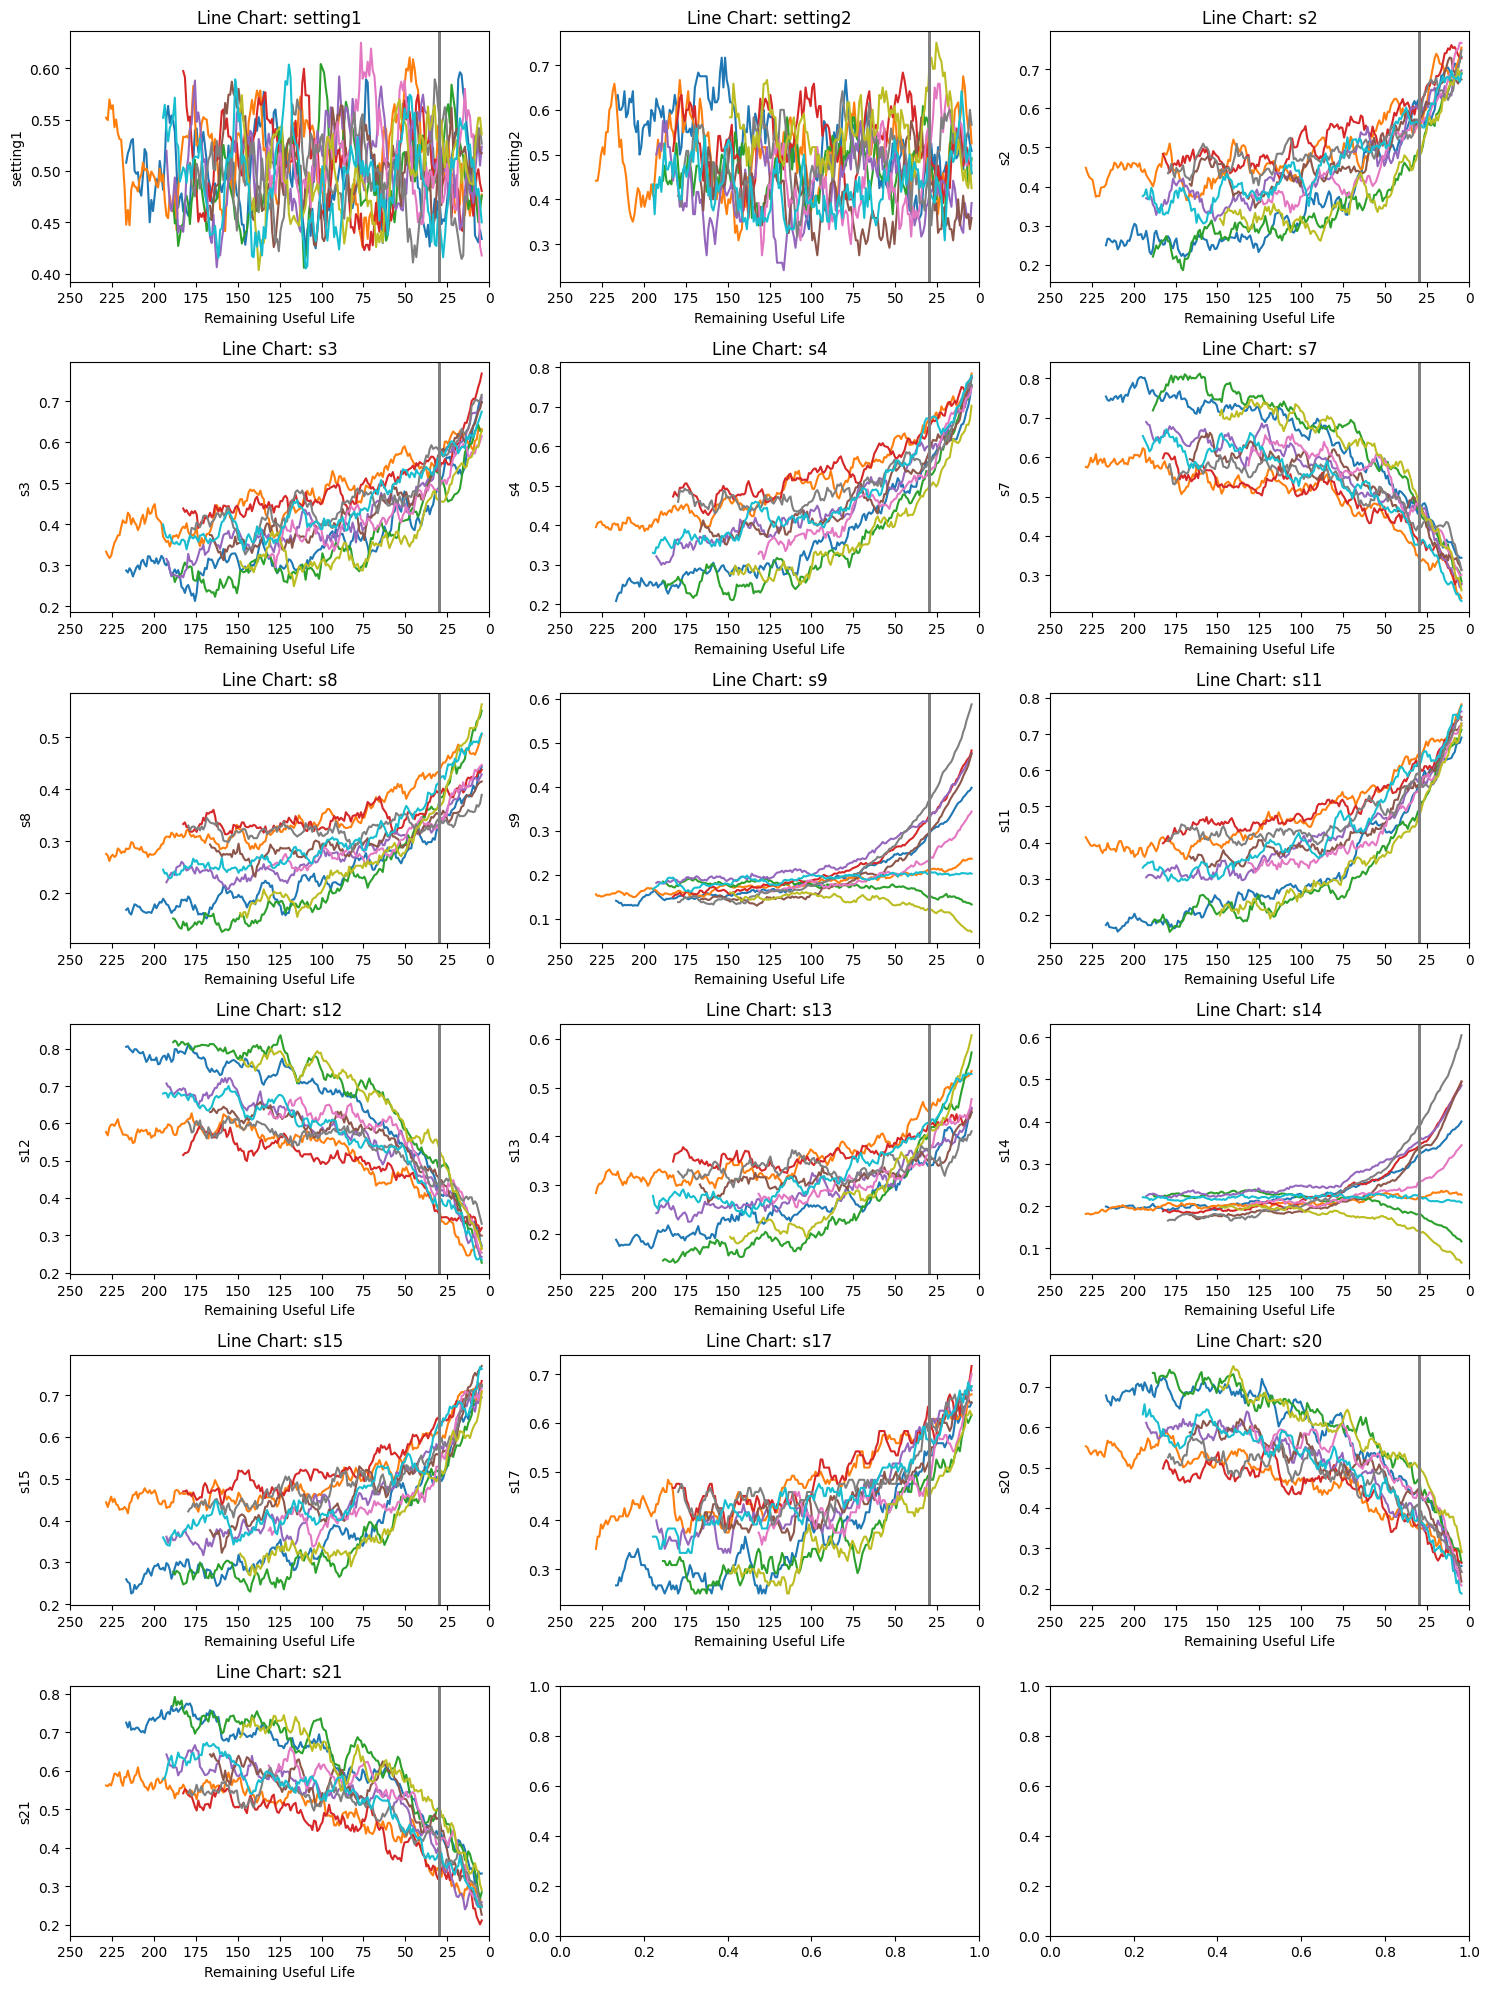

In [15]:

remove_cols = ['setting3', 's1','s5','s6','s10','s16','s18','s19']
valid_cols =  [x for x in plot_cols if x not in remove_cols]

num_rows = 6
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 20))

for i, col in enumerate(valid_cols):
    # Calculate the row and column indices for the current subplot
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Select the current subplot using the row and column indices
    ax = axes[row_idx, col_idx]    
    
    plot_line(col_name=col, df=train_df, window_mvg_avg=10, ax=ax)    
    
# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

#### Test Data: Processing

##### Test Data: Normalized

In [16]:
# create new cycle col
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


##### Test Data: Calculate RUL

In [17]:
# generate column max from the test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

# rename truth_df col from '0' to 'more'
truth_df.columns = ['more']

# # add 1 to zero based index to be equivalent to the unit id in the test dataset
truth_df['id'] = truth_df.index + 1


truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)



In [18]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
# test_df.drop('max', axis=1, inplace=True)
test_df = test_df.drop(columns=[('max')])
test_df.head()



,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


##### Test Data: Create categorical labels

In [19]:
# generate label columns w0 and w1 for test data
test_df['fail_in_30_label'] = np.where(test_df['RUL'] <= cycle_cutoff, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,fail_in_30_label
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


#### Model Building

**Why LSTM?**
The Long Short-Term Memory, or LSTM, network is a type of Recurrent Neural Network (RNN) designed for sequence problems. Sequence prediction is different to other types of supervised learning problems. The sequence imposes an order on the observations that must be preserved when training models and making predictions.

<br> We will use the Keras LSTM with Tensorflow as a backend. 
<br> The incoming data must have a specific 3-dimensional form: (samples, time steps, features)
 - Samples is the number of training sequences (#records)
 - Time Steps is the Sequence length -- aka, the look back window for establishing the sequence
 - Features is the number of features (predictors) of each sequence at each time step

We define a function to generate this array, as we'll use it repeatedly.

Reference: 
- https://machinelearningmastery.com/lstms-with-python/
- https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/

In [20]:
# pick a window size of 50 cycles - this will be used in the generator function below
sequence_length = 50

##### Training data record counts

In [21]:
# How many records does each engine have? None have less than 50 so all engines will be represented
grouped_train_df = train_df.groupby('id').size().reset_index(name='count')
grouped_train_df = grouped_train_df.sort_values('count', ascending=True)

# Filter the DataFrame based on the count condition
count_less_than_seq_length = grouped_train_df[grouped_train_df['count'] < sequence_length]

# Display the resulting DataFrame
print("Number of engines that do not have minimum number of recs:", count_less_than_seq_length.shape[0])

Number of engines that do not have minimum number of recs: 0


In [22]:
# Get the number of rows and columns in df
num_rows = train_df.shape[0]
num_columns = train_df.shape[1]

# Print the result
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 20631
Number of columns: 29


##### Generator Function

In [23]:
# Generator
def gen_sequence(id_df, seq_length, seq_cols):
    '''generates sequences, aka, rolling windows defined by sequence_length.  The result will alway be fewer rows 
    than orig dataset because must have complete sequence_length in a sequence (no padding).  See the example a few cells down
    for what this function does using simple df'''
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]  #rows
    
    # In Python, the zip() function is used to combine elements from two or more iterable objects 
    # and create an iterator that returns tuples containing elements from each of the iterables.
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

##### Get predictor columns

In [24]:
# pick the feature columns 
# recall, we have already decided to remove certain cols based on EDA

key_cols   = ['id', 'cycle']
label_cols = ['fail_in_30_label',  'RUL']

input_features = train_df.columns.values.tolist()
sequence_cols = [x for x in input_features if x not in set(key_cols)]
sequence_cols = [x for x in sequence_cols if x not in set(label_cols)]
sequence_cols = [x for x in sequence_cols if x not in set(remove_cols)]

print(sequence_cols)

['setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21', 'cycle_norm']


##### Example of what the Generator does

In [26]:
# test our the generator using a simple example

# Input DataFrame
id_df = pd.DataFrame({
    'id': [1, 1, 1, 1, 2, 2, 2, 2, 2],
    'value1': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    'value2': [1, 2, 3, 4, 5, 6, 7, 8, 9]
})

print("Data")
print(id_df.head(20))
print("Generator")

# Parameters
seq_length = 3
seq_cols = ['value1', 'value2']

# Generate sequences using the gen_sequence function
sequences = gen_sequence(id_df, seq_length, seq_cols)

# Print the generated sequences
for sequence in sequences:
    print(sequence)


Data
   id  value1  value2
0   1      10       1
1   1      20       2
2   1      30       3
3   1      40       4
4   2      50       5
5   2      60       6
6   2      70       7
7   2      80       8
8   2      90       9
Generator
[[10  1]
 [20  2]
 [30  3]]
[[20  2]
 [30  3]
 [40  4]]
[[30  3]
 [40  4]
 [50  5]]
[[40  4]
 [50  5]
 [60  6]]
[[50  5]
 [60  6]
 [70  7]]
[[60  6]
 [70  7]
 [80  8]]


##### Run Generator

In [27]:
# Run Generator.
# This creates list of lists, where each row in array is a list with predcitor values for one unit: [1,2,3], [2,3,4], etc to 50

seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# to view the list of lists
# for item in seq_gen:
#     print(item) 
    
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

seq_array.shape  #number records, number rows in the sequence, number cols
# seq_array[0]


(15631, 50, 17)

In [28]:

print("Before generator, we had shape:", train_df.shape, "after generator shape is:", seq_array.shape )

Before generator, we had shape: (20631, 29) after generator shape is: (15631, 50, 17)


##### Get labels as an array

In [29]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [30]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['fail_in_30_label']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

label_array.shape
# pd.DataFrame(label_array).head()

(15631, 1)

##### Define the model architecture
- The default activation function is tanh, which transforms the input values between -1 and 1, allowing the LSTM layer to capture and model complex nonlinear relationships in the data.

- LSTM Layer: LSTM is a type of recurrent neural network (RNN) layer specifically designed to handle sequential and time-series data. It is well-suited for capturing long-term dependencies and patterns in sequences

- Dropout layer prevents overfitting

- Dense sigmoid layer - is a basic layer used for general-purpose neural networks that don't require handling sequential or temporal information.


In [32]:
# Set the random seed for reproducibility
np.random.seed(42)
tensorflow.random.set_seed(42)

nb_features = seq_array.shape[2]  #25 predictors

# label_array.shape is (15631, 1)
nb_out = label_array.shape[1]     #1 col

# LSTM model
model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,  #number of memory cells or hidden units in the LSTM layer
         return_sequences=True))  #whether the LSTM layer should return a sequence of outputs or just the final output. 

# Plus a 20% dropout rate - this is used to avoid overfitting
model.add(Dropout(0.2))

# The second layer
model.add(LSTM(
          units=50,
          return_sequences=False))

# Plus a 20% dropout rate
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))

# With adam optimizer and a binary crossentropy loss for classification. We will optimize for model accuracy.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Verify the architecture 
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 100)           47200     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 77451 (302.54 KB)
Trainable params: 77451 (302.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


##### Fit the model
##### Notes: 
- "patience" = the value of "patience" is set to 5, so if there is no improvement in the validation loss for 5 consecutive epochs, the training will be stopped.
- mode = specifies the direction of improvement to be monitored. It can take values such as 'auto', 'min', or 'max'. In this case, "mode" is set to 'auto', which means the direction of improvement is automatically inferred from the monitored metric.  Our metric is accuracy - 'auto' mode would stop training when the accuracy stops increasing

In [33]:
%%time
# fit the network

# Set the random seed for reproducibility
np.random.seed(42)
tensorflow.random.set_seed(42)


model.fit(seq_array, # Training features
          label_array, # Training labels
          epochs=10,   # We'll stop after 10 epochs
          batch_size=200, # 
          validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1, #
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', # Monitor the validation loss
                                                     min_delta=0,    # until it doesn't change (or gets worse)
                                                     patience=5,  # patience > 1 so it continutes if it is not consistently improving
                                                     verbose=0, 
                                                     mode='auto')]) 

Epoch 1/10
71/71 [==============================] - 14s 153ms/step - loss: 0.2561 - accuracy: 0.8860 - val_loss: 0.1192 - val_accuracy: 0.9316
Epoch 2/10
71/71 [==============================] - 11s 149ms/step - loss: 0.1103 - accuracy: 0.9561 - val_loss: 0.0761 - val_accuracy: 0.9629
Epoch 3/10
71/71 [==============================] - 11s 148ms/step - loss: 0.0762 - accuracy: 0.9670 - val_loss: 0.0593 - val_accuracy: 0.9789
Epoch 4/10
71/71 [==============================] - 11s 150ms/step - loss: 0.0700 - accuracy: 0.9711 - val_loss: 0.0513 - val_accuracy: 0.9763
Epoch 5/10
71/71 [==============================] - 11s 158ms/step - loss: 0.0680 - accuracy: 0.9714 - val_loss: 0.0563 - val_accuracy: 0.9731
Epoch 6/10
71/71 [==============================] - 11s 161ms/step - loss: 0.0633 - accuracy: 0.9747 - val_loss: 0.0561 - val_accuracy: 0.9751
Epoch 7/10
71/71 [==============================] - 11s 154ms/step - loss: 0.0658 - accuracy: 0.9726 - val_loss: 0.0422 - val_accuracy: 0.9834

##### Get probabilities from the model
- What is the probability that the engine will fail in the next 30 cycles?

In [34]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_pred

79/79 [==============================] - 5s 52ms/step


array([[7.9513469e-05],
       [8.0487815e-05],
       [8.1839054e-05],
       ...,
       [9.9850112e-01],
       [9.9876046e-01],
       [9.9879408e-01]], dtype=float32)

##### Customize Metrics

##### Customized cost function
 - This function assigns a cost of "20" to false negatives, and "0.5" to false positives.  These costs are relative to each other and can be modified by business users.  The costs are summed to get a total cost.  
 - The number of false positives and negatives is directly impacted by the probability cutoff value.  For example, we can decide that a probability > 0.8 should be considered "fail within 30 cycles", or, we could be more conservative and say that anything > 0.2 should be considered a failure.  Thus, we try many cutoff values and use the one that minimizes the total cost.  

In [37]:
def compute_metrics(y_pred, label_array, cutoff=0.5, fn_cost=20, fp_cost=0.5):
    '''This function calculates metrics for various probability cutoff values 
    if the function is called with a cutoff value of 0.  Otherwise, the user can call the function
    with a specific cutoff value > 0, in which case that cutoff value will be used.  The cutoff value(s)
    are applied and the metrics for classification are calculated an added to a dataframe.  The dataframe is sorted
    in ascending order by cost, so the first row will have cutoff value (threshold) and all of the metric results for the lowest cost'''
    
    if cutoff > 0:
        threshold_list = [cutoff]
    else:
        threshold_list = np.arange(0.005, 0.5, 0.005)

    results = pd.DataFrame(columns=['threshold', 'fn_cost', 'fp_cost', 'precision', 'sensitivity', 'specificity',
                                    'false_neg_rate', 'false_pos_rate', 'f1','TP', 'TN', 'FP', 'FN', 'cost'])

    for threshold in threshold_list:
        # Make predictions and compute confusion matrix
        # y_pred = model.predict(seq_array, verbose=1, batch_size=200)
        y_pred_out = np.where(y_pred >= threshold, 1, 0)

        # Label
        y_true = label_array

        cm = confusion_matrix(y_true, y_pred_out)

        # Compute precision and recall
        precision = precision_score(y_true, y_pred_out)
        recall = recall_score(y_true, y_pred_out)  # aka sensitivity

        TN = cm[0, 0]  # True negatives
        FP = cm[0, 1]  # False positives
        FN = cm[1, 0]  # False negatives
        TP = cm[1, 1]  # True positives

        specificity = TN / (TN + FP)
        false_neg_rate = FN / ( FN + TP)
        false_pos_rate = FP / ( FP + TN)

        f1 = 2 * (precision * recall) / (precision + recall)

        cost = fn_cost * FN + fp_cost * FP

        # Store results in a DataFrame
        result_row = pd.DataFrame({
            'threshold': threshold,
            'fn_cost': fn_cost,
            'fp_cost': fp_cost,
            'precision': precision,
            'sensitivity': recall,
            'specificity': specificity,
            'false_neg_rate': false_neg_rate,
            'false_pos_rate': false_pos_rate,
            'f1': f1,
            'TP': TP,
            'TN': TN,
            'FP': FP,
            'FN': FN,
            'cost': cost
        }, index=[threshold])  # Use threshold as the index

        results = pd.concat([results, result_row])
        results = results.sort_values('cost', ascending=True)  # Sort by cost column
    return results

    
    


In [36]:
# Results over many thresholds - we are trying to reduce the overall "cost"
train_results_df = compute_metrics(y_pred, label_array, cutoff=0, fn_cost=20, fp_cost=0.5)
train_results_df

,threshold,fn_cost,fp_cost,precision,sensitivity,specificity,false_neg_rate,false_pos_rate,f1,TP,TN,FP,FN,cost
0.035,0.035,20,0.5,0.788095,0.999355,0.933525,0.000645,0.066475,0.881240,3098,11698,833,2,456.5
0.040,0.040,20,0.5,0.795939,0.999032,0.936637,0.000968,0.063363,0.885996,3097,11737,794,3,457.0
0.030,0.030,20,0.5,0.779371,0.999355,0.930014,0.000645,0.069986,0.875760,3098,11654,877,2,478.5
0.025,0.025,20,0.5,0.768030,0.999677,0.925305,0.000323,0.074695,0.868676,3099,11595,936,1,488.0
0.020,0.020,20,0.5,0.752062,1.000000,0.918442,0.000000,0.081558,0.858488,3100,11509,1022,0,511.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.475,0.475,20,0.5,0.972279,0.916452,0.993536,0.083548,0.006464,0.943540,2841,12450,81,259,5220.5
0.480,0.480,20,0.5,0.973223,0.914516,0.993775,0.085484,0.006225,0.942957,2835,12453,78,265,5339.0
0.485,0.485,20,0.5,0.973168,0.912581,0.993775,0.087419,0.006225,0.941901,2829,12453,78,271,5459.0
0.490,0.490,20,0.5,0.973494,0.912258,0.993855,0.087742,0.006145,0.941882,2828,12454,77,272,5478.5


##### Optimal cutoff value

In [38]:
optimal_threshold = round(train_results_df['threshold'].iloc[0],3)

print("Optimal Threshold", optimal_threshold)

Optimal Threshold 0.035


#### Model testing
Next, we look at the performance on the test data. Some engines will be excluded because they do not have enough records based on the sequence_length we defined earlier.  Also, for evaluation of the model, only the last cycle data for each engine id in the test data is used. <br> 

In [40]:
test = []
for id in test_df['id'].unique():
    if len(test_df[test_df['id'] == id]) >= 50:
        test.append(id)
len(test)
print("Starting with 100 units, there are",len(test), "units that have >50 records" )

Starting with 100 units, there are 93 units that have >50 records


##### Test Data: Convert to array

In [45]:
# We are taking the last 50 records for each engine id that has at least 50 cycles  
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("shape is:", seq_array_test_last.shape) #number of unique unit lists, lookback number, number of columns
seq_array_test_last

shape is: (93, 50, 17)


array([[[0.3505747 , 0.8333333 , 0.3945783 , ..., 0.4728682 ,
         0.45457056, 0.21052632],
        [0.39655173, 0.5833333 , 0.41265061, ..., 0.6511628 ,
         0.5608948 , 0.2132964 ],
        [0.5114943 , 0.25      , 0.43674698, ..., 0.6356589 ,
         0.4975145 , 0.21606648],
        ...,
        [0.43678162, 0.75      , 0.5572289 , ..., 0.41860464,
         0.4710025 , 0.34072024],
        [0.5804598 , 0.6666667 , 0.6114458 , ..., 0.3255814 ,
         0.45954156, 0.3434903 ],
        [0.40804598, 0.8333333 , 0.50301206, ..., 0.6124031 ,
         0.52444077, 0.3462604 ]],

       [[0.55172414, 0.25      , 0.3313253 , ..., 0.5503876 ,
         0.6974593 , 0.15512465],
        [0.39655173, 0.5833333 , 0.29216868, ..., 0.37209302,
         0.59748685, 0.15789473],
        [0.5344828 , 0.16666667, 0.49698794, ..., 0.51937985,
         0.602596  , 0.16066483],
        ...,
        [0.43103448, 0.33333334, 0.4939759 , ..., 0.56589144,
         0.49461475, 0.28531855],
        [0.3

##### Get ids >= threshold 

In [46]:
# Create a boolean list identifying each engine id as True (has >= 50 records) or False
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
print(y_mask)


[False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


##### Get labels

In [47]:
# Filter test_df for the ids where y_mask is True
# .nth(-1) is used as part of the groupby() operation in pandas to retrieve the last value within each group
# this will indicate if the 50th record was a 0 or 1
label_array_test_last = test_df.groupby('id')['fail_in_30_label'].nth(-1)[y_mask].values
print(label_array_test_last)
print(label_array_test_last.shape)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1]
(93,)


##### Get probabilities for testing data
Now we can test the model with the test data. 
We will use the optimal threshold probability calculated from the training data.   
Training metrics are likely to be better, as the model was trained on this data.  
The test data metrics is more realistic as it represents unseen data and gives us an idea of how this will perform with new data.

In [48]:
y_pred_test = model.predict(seq_array_test_last)

3/3 [==============================] - 0s 14ms/step


##### Test Data Confusion Matrix / Metrics

In [49]:
testresults_df = compute_metrics(y_pred_test, label_array_test_last, cutoff=optimal_threshold, fn_cost=20, fp_cost=0.5)
testresults_df

,threshold,fn_cost,fp_cost,precision,sensitivity,specificity,false_neg_rate,false_pos_rate,f1,TP,TN,FP,FN,cost
0.035,0.035,20,0.5,0.892857,1.0,0.955882,0.0,0.044118,0.943396,25,65,3,0,1.5


##### Conclusion: 
- Our metrics are:  precision, sensitivity, specificity.  
- Surprisingly, our test data outperformed training data.  
- The cost assigned to false negatives was high compared to false positives, so this drove the sensitivity to be a perfect - **there were no false negatives when running the test data**.  
 - **Specificity was also excellent, so overall we struck a very good balance**.  
 - The probability cutoff that powered these results was < 0.1, which, compared to the default of 0.5 is biased toward the low end.  But, this cutoff is a user-defined business decision, so this is something that can be adjusted by altering the penalty associated with false positives and negatives.  

Overall, the LSTM model, using a window sequence of 50 records, with just a few hidden layers, did an excellent job when training the model.


In [50]:
print("Train Precision:", round(train_results_df['precision'].iloc[0],3), "Test:", round(testresults_df['precision'].iloc[0],3),'\n',
      "Train Sensitivity:", round(train_results_df['sensitivity'].iloc[0],3), "Test:", round(testresults_df['sensitivity'].iloc[0],3),'\n',
      "Train Specificity:", round(train_results_df['specificity'].iloc[0],3), "Test:", round(testresults_df['specificity'].iloc[0],3),'\n',
      )

Train Precision: 0.788 Test: 0.893 
 Train Sensitivity: 0.999 Test: 1.0 
 Train Specificity: 0.934 Test: 0.956 



#### Bonus:  Saving the model
The LSTM network is made up of two components, the architecture and the model weights. We'll save these model components in two files:
- the architecture in a json file that the keras package can use to rebuild the model
- the weights in an HDF5 heirachy that rebuild the exact model.

In [ ]:
# We'll serialize the model in json format
LSTM_MODEL = 'modellstm.json' #assigns the string value 'modellstm.json' to the variable LSTM_MODEL.

# and store the weights in h5
MODEL_WEIGHTS = 'modellstm.h5'

In [ ]:
# Save the model for operationalization: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# save model
# serialize model to JSON
model_json = model.to_json()
with open(LSTM_MODEL, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(MODEL_WEIGHTS)
print("Model saved")

##### Import & run saved model

In [ ]:
print(keras.__version__)

# load json and create model
json_file = open(LSTM_MODEL, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(MODEL_WEIGHTS)

loaded_model.compile('sgd','mse')
print("Model loaded")

In [ ]:
# test it out!
score = loaded_model.predict(seq_array,verbose=1)
print(score.shape)
print(score)